# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [2]:
# Import libraries
import re
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, split, udf, isnull, when, regexp_replace, first
from pyspark.sql.functions import max as fmax
from pyspark.sql.types import IntegerType, StringType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier,RandomForestClassifier

In [3]:
# Create a local Spark session 
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
# Load data
sparkify_event_data = 'mini_sparkify_event_data.json'
df = spark.read.json(sparkify_event_data)

# Display data keys and types
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [4]:
# Print the first row of the data
df.show(10)

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|    Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Bost

In [5]:
# Print schema in more of a readable manner
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
# Print summary of userId and sessionId columns
df.describe(['userId', 'sessionId']).show()
print("Total row count:", df.count())

+-------+-----------------+-----------------+
|summary|           userId|        sessionId|
+-------+-----------------+-----------------+
|  count|           286500|           286500|
|   mean|59682.02278593872|1041.526554973822|
| stddev|109091.9499991047|726.7762634630741|
|    min|                 |                1|
|    max|               99|             2474|
+-------+-----------------+-----------------+

Total row count: 286500


In [7]:
# Print number of nulls in userId and sessionId
print("Number of nulls in userId: ", df.filter(isnull(df['userId'])).count())
print("Number of nulls in sessionId: ", df.filter(isnull(df['sessionId'])).count())

Number of nulls in userId:  0
Number of nulls in sessionId:  0


In [8]:
# Print number of blanks in userId and sessionId
print("Number of blanks in userId: ", df.filter(df['userId'] == '').count())
print("Number of blanks in sessionId: ", df.filter(df['sessionId'] == '').count())

Number of blanks in userId:  8346
Number of blanks in sessionId:  0


In [4]:
def clean_data(df):
    """
    Function to clean data
    :param df: Spark dataframe
    return df: Cleaned spark dataframe
    """
    
    # Remove records with blanks in userId
    df = df.filter(df['userId'] != '')
    
    # Create user defined function to convert format of timestamp (ts)
    convert_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
    
    # Convert timestamp (ts) to different format
    df = df.withColumn("time", convert_time(df.ts))
    
    # Separate city and state
    df = df.withColumn('state', split(col('location'),',').getItem(1))
    
    return df

# Run function and print first row of cleaned data
df = clean_data(df)
df.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', time='2018-10-01 00:01:57', state=' CA')]

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [5]:
def define_label(df):
    """
    Function to add the label column (Churn) in the data
    :param df: Spark dataframe
    return df: Spark dataframe with a label column
    """
    # Create user defined function to indicate whether or not customer churned
    churn_indicator = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
    
    # Create column indicating whether or not customer churned
    df = df.withColumn('Churned', churn_indicator('page'))
    
    # Create label for Churn
    userwindow = Window.partitionBy('userId').rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
    df = df.withColumn('Churn',fmax('Churned').over(userwindow))
    
    return df

# Run function and print first row of cleaned data with label column
df = define_label(df)
df.take(1)

[Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', Churned=0, Churn=0)]

In [11]:
# Create temporary view to run SQL commands
df.createOrReplaceTempView("Sparkify_Data")

In [12]:
# Test to see if everything is ready 
spark.sql('''
        SELECT *
        FROM Sparkify_Data
        LIMIT 5
''').show()

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+------+-------------------+-----+-------+-----+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|     page| registration|sessionId|                song|status|           ts|           userAgent|userId|               time|state|Churned|Churn|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+------+-------------------+-----+-------+-----+
|Sleeping With Sirens|Logged In| Darianna|     F|            0|Carpenter|202.97098| free|Bridgeport-Stamfo...|   PUT| NextSong|1538016340000|       31|Captain Tyin Knot...|   200|1539003534000|"Mozilla/5.0 (iPh...|

In [13]:
# Look at user counts for the unique auth values
user_count = spark.sql('''
        SELECT auth, COUNT(DISTINCT userId) AS user_count
        FROM Sparkify_Data
        GROUP BY auth
        ORDER BY user_count
''')
user_count.show()

+---------+----------+
|     auth|user_count|
+---------+----------+
|Cancelled|        52|
|Logged In|       225|
+---------+----------+



In [14]:
# Look at user counts by gender
gender_count = spark.sql('''
        SELECT gender, COUNT(DISTINCT userId) AS user_count
        FROM Sparkify_Data
        GROUP BY gender
        ORDER BY user_count
''')
gender_count.show()

+------+----------+
|gender|user_count|
+------+----------+
|     F|       104|
|     M|       121|
+------+----------+



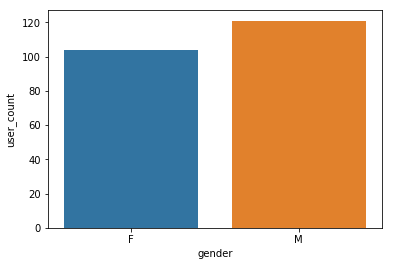

In [15]:
# Create bar chart of gender count
sns.barplot(x='gender', y='user_count', data=gender_count.toPandas());

The number of males vs females seems to be fairly balanced (not confirmed through statistical significance) with the number of males being slightly larger than the number of females in the dataset.

In [16]:
# Look at unique itemInSession count
item_count = spark.sql('''
        SELECT COUNT(DISTINCT(itemInSession)) AS item_count
        FROM Sparkify_Data
''')
item_count.show()

+----------+
|item_count|
+----------+
|      1311|
+----------+



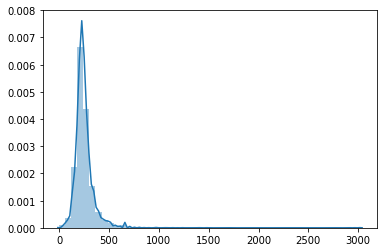

In [17]:
# Create distibution plot of length
sns.distplot(spark.sql('''
        SELECT length
        FROM Sparkify_Data
''').toPandas().dropna());

In [18]:
# Look at unique level user counts
level_count = spark.sql('''
        SELECT level, COUNT(DISTINCT userId) AS user_count
        FROM Sparkify_Data
        GROUP BY level
        ORDER BY user_count
''')
level_count.show()

+-----+----------+
|level|user_count|
+-----+----------+
| paid|       165|
| free|       195|
+-----+----------+



In [19]:
# Look at unique user counts by top 10 states
state_count = spark.sql('''
        SELECT state, COUNT(DISTINCT userId) AS user_count
        FROM Sparkify_Data
        GROUP BY state
        ORDER BY user_count DESC
        LIMIT 10
''')
state_count.show()

+---------+----------+
|    state|user_count|
+---------+----------+
|       CA|        33|
|       TX|        16|
| NY-NJ-PA|        15|
|       FL|        14|
|       AZ|         7|
|       CT|         7|
| IL-IN-WI|         6|
|    MO-IL|         6|
|    NC-SC|         6|
|       NC|         6|
+---------+----------+



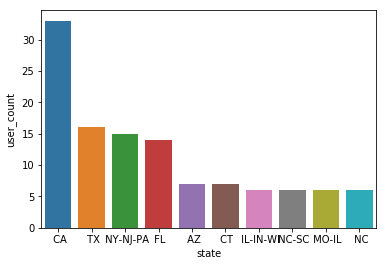

In [20]:
# Create bar chart of top 10 state count
sns.barplot(x='state', y='user_count', data=state_count.toPandas());

California is the most popular state amongst the users in our dataset, followed by Texas and New York-New Jersey-Pennsylvania.

In [21]:
# Look at unique user counts by page
page_count = spark.sql('''
        SELECT page, COUNT(userId) AS user_count
        FROM Sparkify_Data
        GROUP BY page
        ORDER BY user_count
''')
page_count.show()

+--------------------+----------+
|                page|user_count|
+--------------------+----------+
|Cancellation Conf...|        52|
|              Cancel|        52|
|    Submit Downgrade|        63|
|      Submit Upgrade|       159|
|               Error|       252|
|       Save Settings|       310|
|               About|       495|
|             Upgrade|       499|
|                Help|      1454|
|            Settings|      1514|
|           Downgrade|      2055|
|         Thumbs Down|      2546|
|              Logout|      3226|
|         Roll Advert|      3933|
|          Add Friend|      4277|
|     Add to Playlist|      6526|
|                Home|     10082|
|           Thumbs Up|     12551|
|            NextSong|    228108|
+--------------------+----------+



In [22]:
# Look at unique user counts by userAgent from highest to lowest
userAgent_count = spark.sql('''
        SELECT userAgent, COUNT(DISTINCT userId) AS user_count
        FROM Sparkify_Data
        GROUP BY userAgent
        ORDER BY user_count DESC
''')
userAgent_count.show()

+--------------------+----------+
|           userAgent|user_count|
+--------------------+----------+
|"Mozilla/5.0 (Win...|        24|
|Mozilla/5.0 (Wind...|        18|
|"Mozilla/5.0 (Mac...|        16|
|"Mozilla/5.0 (Mac...|        12|
|"Mozilla/5.0 (Mac...|        12|
|"Mozilla/5.0 (Mac...|        10|
|"Mozilla/5.0 (Win...|        10|
|Mozilla/5.0 (Maci...|         9|
|"Mozilla/5.0 (iPh...|         8|
|"Mozilla/5.0 (Mac...|         7|
|"Mozilla/5.0 (Win...|         7|
|Mozilla/5.0 (Wind...|         7|
|"Mozilla/5.0 (Win...|         5|
|"Mozilla/5.0 (iPh...|         4|
|"Mozilla/5.0 (X11...|         4|
|Mozilla/5.0 (Wind...|         4|
|Mozilla/5.0 (X11;...|         4|
|"Mozilla/5.0 (Win...|         4|
|"Mozilla/5.0 (Win...|         4|
|"Mozilla/5.0 (Win...|         4|
+--------------------+----------+
only showing top 20 rows



In [23]:
def define_browser(x):
    """
    Define function to get browser
    :param x: string containing substring of browser
    return string: string representing browser
    """
    if 'Firefox' in x:
        return 'Firefox'
    elif 'Safari' in x:
        if 'Chrome' in x:
            return 'Chrome'
        else:
            return 'Safari'
    elif 'Trident' in x:
        return 'IE'
    else:
        return np.NaN

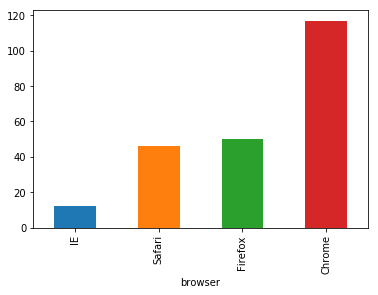

In [24]:
# Create column for browser and plot
userAgent_count = userAgent_count.toPandas()
userAgent_count['browser'] = userAgent_count['userAgent'].apply(define_browser)
userAgent_count.groupby('browser')['user_count'].sum().sort_values().plot(kind='bar');

The most common browser is Chrome, followed by Firefox, Safari and IE.

In [25]:
# Extract time component
time_data = spark.sql('''
        SELECT time, userId
        FROM Sparkify_Data
''')
time_data.show()

+-------------------+------+
|               time|userId|
+-------------------+------+
|2018-10-01 00:01:57|    30|
|2018-10-01 00:03:00|     9|
|2018-10-01 00:06:34|    30|
|2018-10-01 00:06:56|     9|
|2018-10-01 00:11:16|    30|
|2018-10-01 00:11:18|     9|
|2018-10-01 00:14:46|     9|
|2018-10-01 00:14:59|    30|
|2018-10-01 00:15:05|    30|
|2018-10-01 00:18:04|    30|
|2018-10-01 00:19:06|     9|
|2018-10-01 00:19:10|     9|
|2018-10-01 00:20:18|    30|
|2018-10-01 00:22:55|     9|
|2018-10-01 00:22:56|     9|
|2018-10-01 00:24:01|    30|
|2018-10-01 00:26:16|     9|
|2018-10-01 00:27:48|    74|
|2018-10-01 00:28:07|    30|
|2018-10-01 00:29:04|     9|
+-------------------+------+
only showing top 20 rows



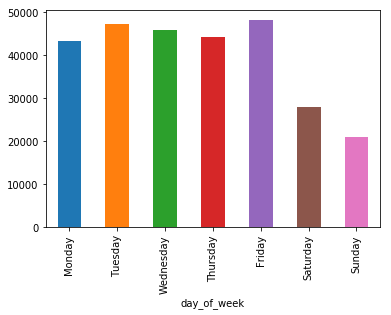

In [26]:
# Extract day of week, day and hour from time data
time_data = time_data.toPandas()
time_data['time'] = pd.to_datetime(time_data['time'])
conv_dict = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
time_data['day_of_week'] = time_data['time'].dt.weekday.map(conv_dict)
time_data['day'] = time_data['time'].dt.day
time_data['hour'] = time_data['time'].dt.hour

# Plot number of unique users by day of week
time_data.groupby('day_of_week')['userId'].count().loc[list(conv_dict.values())].plot(kind='bar');

Based on the plot above, it can be seen that Sparkify is more popular in the weekdays than on the weekends.

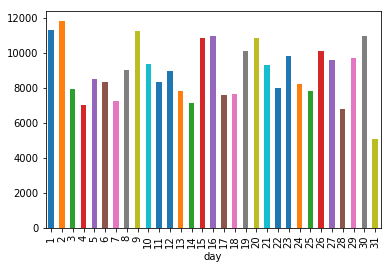

In [27]:
# Plot number of unique users by day of month
time_data.groupby('day')['userId'].count().plot(kind='bar');

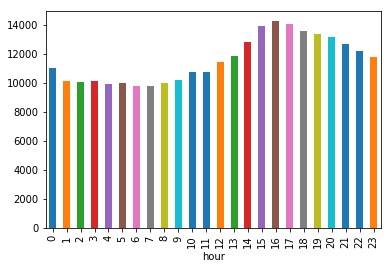

In [28]:
# Plot number of unique users by hour of day
time_data.groupby('hour')['userId'].count().plot(kind='bar');

Based on the above plot, it appears that more users use Sparkify in the late-afternoon to evening hours as opposed to the morning hours.

In [29]:
# Get number of churned vs unchurned users in dataset
df.dropDuplicates(['userId']).select('Churn').groupby('Churn').count().collect()

[Row(Churn=1, count=52), Row(Churn=0, count=173)]

Given that 173 users did not churn and only 52 churned, the dataset contains an (although not too extreme) imbalance.

In [30]:
# Look at churn by gender
df.dropDuplicates(["userId", "gender"]).groupby(["Churn", "gender"]).count().sort("Churn").show()

+-----+------+-----+
|Churn|gender|count|
+-----+------+-----+
|    0|     M|   89|
|    0|     F|   84|
|    1|     F|   20|
|    1|     M|   32|
+-----+------+-----+



The churn rate in males is slightly higher (~26%) than in females (~19%), although it may or may not a statistically significant difference.

In [31]:
# Look at churn by level
df.dropDuplicates(["userId"]).groupby(["Churn", "level"]).count().sort("Churn").show()

+-----+-----+-----+
|Churn|level|count|
+-----+-----+-----+
|    0| free|  133|
|    0| paid|   40|
|    1| paid|    8|
|    1| free|   44|
+-----+-----+-----+



The churn rate in the free level is slightly higher (~25%) than in the paid level (~17%), although it may or may not a statistically significant difference.

In [32]:
def get_props(data):
    """
    Function to normalize the data
    :param data: pandas dataframe containing data
    return: pandas dataframe with the normalized column
    """
    grouped_data = data.set_index(list(data.columns[:2]))
    unstacked_grouped_data = grouped_data.unstack('Churn').fillna(0)
    out = pd.DataFrame(((unstacked_grouped_data - unstacked_grouped_data.min()) / 
                       (unstacked_grouped_data.max() - unstacked_grouped_data.min())).stack()).reset_index()
    out = out.rename(columns={out.columns[-1]:'prop_col'})
    return out

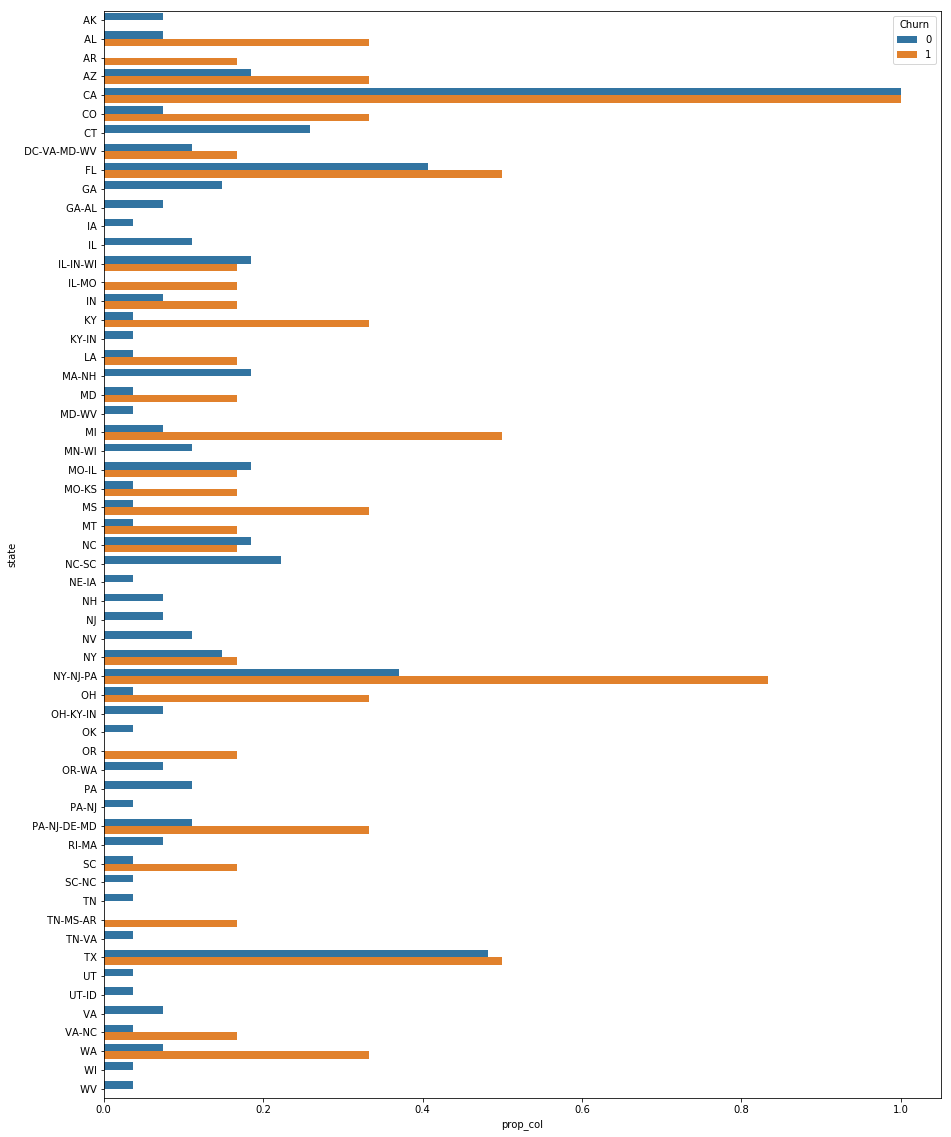

In [33]:
# Plot proportion of users that churned / not churned by state
state_data = get_props(df.dropDuplicates(["userId"]).groupby(["state","Churn"]).count().sort("state").toPandas())
fig, ax = plt.subplots(figsize=(15,20))
sns.barplot(x="prop_col", y="state", hue="Churn", data=state_data, ax=ax);

We see that the proportion of those who churned is very close in CA, but fairly different in NY-NJ-PA.

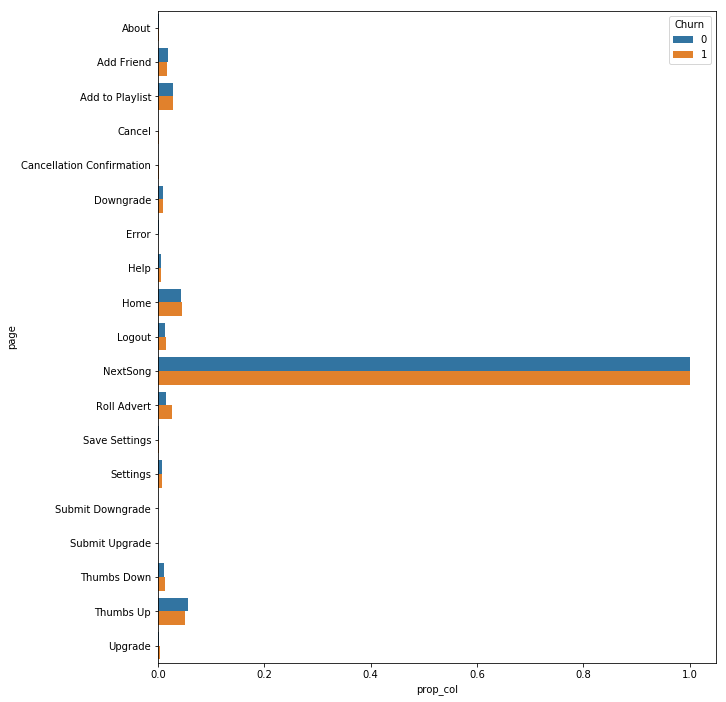

In [34]:
# Plot proportion of users that churned / not churned by page
page_data = get_props(df.groupby(["page","Churn"]).count().sort("page").toPandas())
fig, ax = plt.subplots(figsize=(10,12))
sns.barplot(x="prop_col", y="page", hue="Churn", data=page_data, ax=ax);

The biggest impact on whether a customer churned or not is primarily determined by Add Friend, Add to Playlist, Home, NextSrong, Roll Advert, Thumbs Down and Thumps Up.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [6]:
def feature_engineering(df):
    """
    Function to conduct feature engineering on the dataset
    :param df: dataframe containing the clean data
    return: dataframe with feature engineering completed
    """
    # Remove special characters from string fields
    for field in df.schema.fields:
        if field.dataType==StringType():
            df = df.withColumn(field.name, regexp_replace(field.name, '[^a-zA-Z0-9\,\-]', ''))

    # Length of time in days between registration and latest activity
    latest_activity_df = df.groupby('userId').agg(fmax('ts').alias('latest_activity'))
    df = latest_activity_df.join(df, on='userId')
    df = df.withColumn('days_active', ((col('latest_activity')-col('registration'))/86400000).cast(IntegerType()))
    
    # Latest level
    latest_level_df = df.orderBy('ts', ascending=False).groupby('userId').agg(first('level').alias('latest_level'))
    df = df.drop('level')
    df = df.join(latest_level_df, on='userId')
    
    # Average length
    average_length_df = df.groupby('userId').avg('length').withColumnRenamed('avg(length)', 'length')
    df = df.drop('length')
    df = df.join(average_length_df, on='userId')
    
    # Number of unique songs
    unique_songs_df = df.filter(df.page=='NextSong').select(["userId","song"]).\
                            dropDuplicates(["userId","song"]).groupby(["userId"]).count()
    unique_songs_df = unique_songs_df.withColumnRenamed('count','unique_songs')
    df = df.join(unique_songs_df, on='userId')
    
    # Total number of songs
    total_songs_df = df.filter(df.page=='NextSong').select(["userId","song"]).groupby(["userId"]).count()
    total_songs_df = total_songs_df.withColumnRenamed('count','total_songs')
    df = df.join(total_songs_df, on='userId')

    # Select only those features going into the model
    cols_to_keep = ['userId','days_active','length','unique_songs','total_songs','gender','latest_level','Churn']
    df_shortened = df.select(cols_to_keep)
    df_shortened = df_shortened.drop_duplicates()
    df_shortened = df_shortened.drop('userId')
    

    # Rename Churn to label
    df_shortened = df_shortened.withColumnRenamed('Churn','label')
    
    return df_shortened

# Run feature engineering function
df_shortened = feature_engineering(df)

In [7]:
# Convert gender to numerical feature
gender_indexer = StringIndexer(inputCol="gender", outputCol="gender_ohe")

# Convert latest level to numerical feature
latest_level_indexer = StringIndexer(inputCol="latest_level", outputCol="latest_level_ohe")

# Create feature vector
feature_list = ['days_active','length','unique_songs','total_songs','gender_ohe','latest_level_ohe']
vector = VectorAssembler(inputCols=feature_list, outputCol='features')

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [8]:
# Split data into train and test sets
train, test = df_shortened.randomSplit([0.7, 0.3], seed=42)

# Initialize models to test
clf_lr = LogisticRegression(maxIter=50)
clf_dt = DecisionTreeClassifier(seed=42)
clf_rf = RandomForestClassifier(seed=42)

# Set up evaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

In [9]:
# Baseline model
for model in [clf_lr, clf_dt, clf_rf]:
    pipeline = Pipeline(stages=[gender_indexer, latest_level_indexer, vector, model])
    fit_model = pipeline.fit(train)
    preds = fit_model.transform(test)
    f1_score = evaluator.evaluate(preds.select('label','prediction'),{evaluator.metricName: 'f1'})
    print('model, f1_score: ', model, f1_score)

model, f1_score:  LogisticRegression_cf9646acf36e 0.761817812943802
model, f1_score:  DecisionTreeClassifier_8e3cd16ebaa4 0.8009824277105384
model, f1_score:  RandomForestClassifier_7968fdf12d7f 0.7990395657166719


In [25]:
# Save model
pipeline = Pipeline(stages=[gender_indexer, latest_level_indexer, vector, clf_dt])
fit_model = pipeline.fit(train)
fit_model.save('dtmodel')

The best performing model is the Decision Tree Classifier. Below we run parameter tuning on the Decision Tree Classifier. 

In [9]:
# Create ParamGrid for Cross Validation
dtparamGrid = (ParamGridBuilder()
             .addGrid(clf_dt.maxDepth, [2,15,30])
             .addGrid(clf_dt.maxBins, [10,50,100])
             .build())

# Create 5-fold CrossValidator
dtcv = CrossValidator(estimator = clf_dt,
                      estimatorParamMaps = dtparamGrid,
                      evaluator = evaluator,
                      numFolds = 3)

# Create pipeline
pipeline = Pipeline(stages=[gender_indexer, latest_level_indexer, vector, dtcv])

# Run cross validations
dtcvModel = pipeline.fit(train)

# Use test set to evaluate model performance
dtpreds = dtcvModel.transform(test)

# cvModel uses the best model found from the Cross Validation above

# Evaluate best model
best_f1_score = evaluator.evaluate(dtpreds.select('label','prediction'),{evaluator.metricName: 'f1'})
print('best f1_score: ', best_f1_score)

best f1_score:  0.7332635797761975


It turns out that the baseline model with default parameters is performing better than the tuned model. This could potentially be due to the fact that we are overfitting to the training set with the tuned parameters, or not exploring a large enough parameter space, thus decreasing the performance of the model on unseen data.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.